In [1]:
# Move to the directory where the notebook is located
# and set directory to Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
%cd ..

c:\Users\USER\Downloads\chương trình học UEH\môn học kì 4\PPNC\Project\Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Đảm bảo đang ở Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
# Cài đặt package
!pip install -e .

Obtaining file:///C:/Users/USER/Downloads/ch%C6%B0%C6%A1ng%20tr%C3%ACnh%20h%E1%BB%8Dc%20UEH/m%C3%B4n%20h%E1%BB%8Dc%20k%C3%AC%204/PPNC/Project/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for signature_verification (pyproject.toml): started
  Building editable for signature_verification (pyproject.toml): finished with status 'done'
  Created wheel for signature_verification: filename=signature_verification-0.1.0-0.editable-py3-none-any.whl s


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import sys
import time
import gc
import random
import psutil
import shutil
import kagglehub
import itertools

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, precision_recall_curve
)

from models.feature_extractor import ResNetFeatureExtractor
from utils.helpers import load_config, save_model, train_model, train_model_kfold, get_model_from_Kaggle, load_model
from utils.model_evaluation import evaluate_model, draw_plot_evaluate, draw_plot_find_acc
from models.Triplet_Siamese_Similarity_Network import tSSN
from losses.triplet_loss import TripletLoss
from dataloader.tSSN_trainloader import SignatureTrainDataset
from dataloader.tSSN_testloader import SignatureTestDataset

In [4]:
print(os.getcwd())

c:\Users\USER\Downloads\chương trình học UEH\môn học kì 4\PPNC\Project\Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication


## 1. Dataset Processing

In [5]:
dataset = kagglehub.dataset_download("shreelakshmigp/cedardataset")
print("Path to dataset files [shreelakshmigp]:", dataset)
sys.path.append(dataset)

Path to dataset files [shreelakshmigp]: C:\Users\USER\.cache\kagglehub\datasets\shreelakshmigp\cedardataset\versions\1


In [6]:
# Transform chung
transform = transforms.Compose([
    transforms.Resize((220, 150)),
    transforms.Grayscale(),  # Đảm bảo ảnh 1 kênh xám
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 1 kênh -> 3 kênh
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = SignatureTrainDataset(
    org_dir = dataset + '/signatures/full_org',
    forg_dir = dataset + '/signatures/full_forg',
    transform=transform
)

train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, len(dataset) - train_size]
)

train_loader = DataLoader(train_dataset, num_workers=0, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, num_workers=0, batch_size=32, shuffle=False)

In [7]:
# Kiểm tra Triplet Dataset
print(f"Dataset - Total triplets: {len(dataset)}")

anchor, positive, negative = dataset[0]

print(f"Anchor shape: {anchor.shape}")
print(f"Positive shape: {positive.shape}")
print(f"Negative shape: {negative.shape}")

print(f"Training dataset: {len(train_dataset)}")

anchor_train, positive_train, negative_train = train_dataset[0]

print(f"Anchor shape: {anchor_train.shape}")
print(f"Positive shape: {positive_train.shape}")
print(f"Negative shape: {negative_train.shape}")

print(f"Testing dataset: {len(test_dataset)}")

anchor_test, positive_test, negative_test = test_dataset[0]

print(f"Anchor shape: {anchor_test.shape}")
print(f"Positive shape: {positive_test.shape}")
print(f"Negative shape: {negative_test.shape}")

print("LOAD DATASET SUCCESSFULLY")
print(f"Train-Test Split Ratio: {len(train_dataset)/len(dataset)*100:.1f}% - {len(test_dataset)/len(dataset)*100:.1f}%")

Dataset - Total triplets: 1320
Anchor shape: torch.Size([3, 220, 150])
Positive shape: torch.Size([3, 220, 150])
Negative shape: torch.Size([3, 220, 150])
Training dataset: 1056
Anchor shape: torch.Size([3, 220, 150])
Positive shape: torch.Size([3, 220, 150])
Negative shape: torch.Size([3, 220, 150])
Testing dataset: 264
Anchor shape: torch.Size([3, 220, 150])
Positive shape: torch.Size([3, 220, 150])
Negative shape: torch.Size([3, 220, 150])
LOAD DATASET SUCCESSFULLY
Train-Test Split Ratio: 80.0% - 20.0%


## 2. Load Model

- `MemoryTracker`: theo dõi start, peak, end memory  
- Load config, model, transform


In [8]:
# Memory tracking class
class MemoryTracker:
    def __init__(self):
        self.proc = psutil.Process(os.getpid())
        self.start = self.peak = self.end = None

    def start_tracking(self):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        self.start = self.proc.memory_info().rss / 1e6
        self.peak = self.start

    def update(self):
        cur = self.proc.memory_info().rss / 1e6
        self.peak = max(self.peak, cur)

    def end_tracking(self):
        self.end = self.proc.memory_info().rss / 1e6

    def summary(self):
        return {
            'start_MB': self.start,
            'peak_MB': self.peak,
            'end_MB': self.end,
            'delta_MB': self.end - self.start
        }

In [9]:
config = load_config('configs/config_tSSN.yaml')
print(config)
print("LOAD CONFIG SUCCESSFULLY")

{'model': {'name': 'tSSN', 'backbone': 'resnet34', 'feature_dim': 512, 'kaggle_handle': 'giahuytranviet/tSSN-verification-model/pyTorch/default/3'}, 'training': {'batch_size': 32, 'learning_rate': 0.001, 'early_stop': 3, 'optimizer': 'adam', 'num_epochs': 100, 'margin': 0.5, 'scheduler': 'cosine'}, 'dataset': {'train_data_path': './data/triplet/train/', 'val_data_path': './data/triplet/val/', 'input_size': '(220,150)'}, 'device': 'cuda', 'logging': {'log_dir': './logs/', 'checkpoint_dir': './checkpoints/', 'save_freq': 5}}
LOAD CONFIG SUCCESSFULLY


In [10]:
get_model_from_Kaggle(config['model']['kaggle_handle'])

Model downloaded to C:\Users\USER\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\3


'C:\\Users\\USER\\.cache\\kagglehub\\models\\giahuytranviet\\tSSN-verification-model\\pyTorch\\default\\3'

In [11]:
model_path = r'C:\Users\USER\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\3\tSNN_euclidean_0.6'

In [12]:
model = load_model(model_path, config['model']['backbone'], config['model']['feature_dim'])

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model from C:\Users\USER\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\3\tSNN_euclidean_0.6\tSSN.pth


In [13]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() and config['device']=='cuda' else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [14]:
model = torch.nn.DataParallel(model, device_ids=[0])
model.to(device)

DataParallel(
  (module): tSSN(
    (feature_extractor): ResNetFeatureExtractor(
      (backbone): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_s

Evaluating with euclidean: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


Results Table:
   accuracy  precision    recall        f1  roc_auc  threshold                                             y_true                                          distances
0  0.948864   0.957529  0.939394  0.948375  0.98977   4.864354  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  [2.98675274848938, 1.7350050210952759, 3.65145...


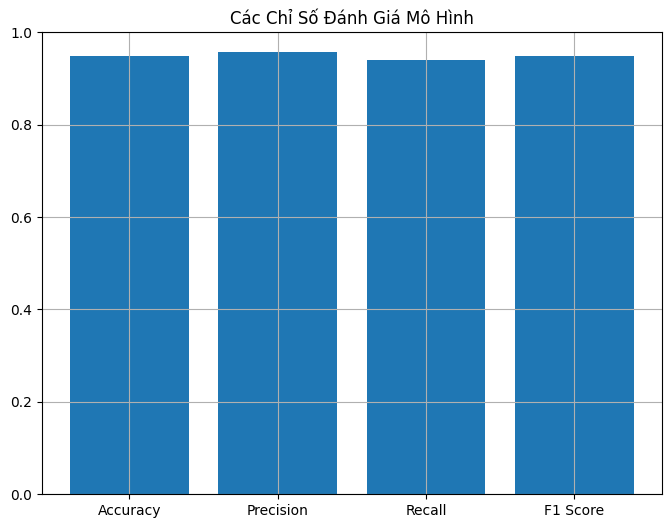

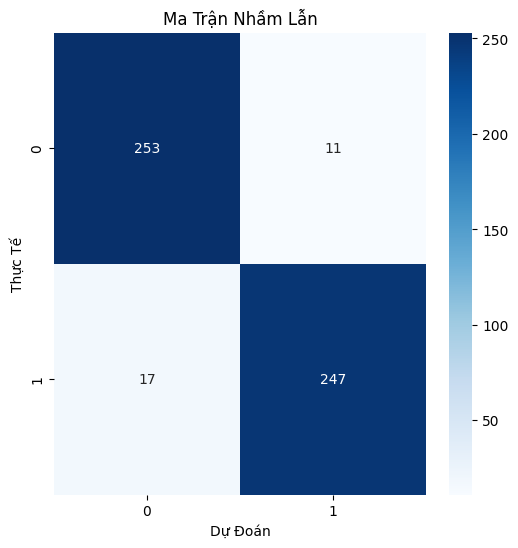

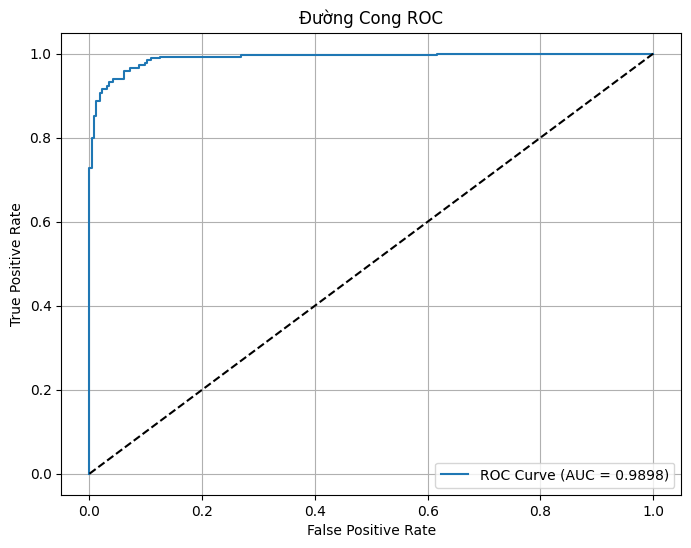

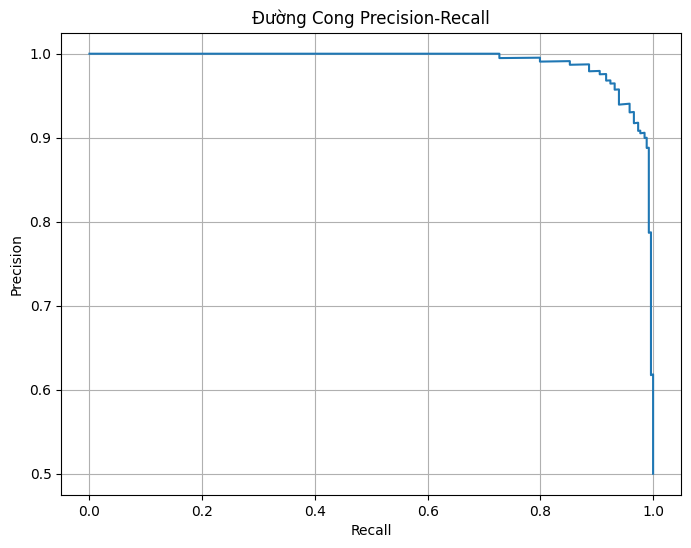

In [15]:
# Đây sẽ là các block đánh giá các thông số của model cuối cùng, kèm theo đó là vẽ plot, cũng như test model
# Hàm đánh giá để trong utils/model_evaluation.py
result = evaluate_model(model, 'euclidean', test_loader, device)

draw_plot_evaluate(result, "all")